# Item sales demand forecasting

### Summary

<b> Observations: </b> HERE

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
df = pd.read_csv('data/train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


### Missing Values Imputation

In [18]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### Data Preprocessing

In [22]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5
...,...,...,...,...,...,...,...
1729,2017-09-26,1,1,18,2017,9,26
1730,2017-09-27,1,1,27,2017,9,27
1731,2017-09-28,1,1,23,2017,9,28
1732,2017-09-29,1,1,28,2017,9,29


In [23]:
test_df

,date,store,item,sales
0,2017-10-01,1,1,21
1,2017-10-02,1,1,12
2,2017-10-03,1,1,18
3,2017-10-04,1,1,15
4,2017-10-05,1,1,20
...,...,...,...,...
87,2017-12-27,1,1,14
88,2017-12-28,1,1,19
89,2017-12-29,1,1,15
90,2017-12-30,1,1,27


### EDA Plots

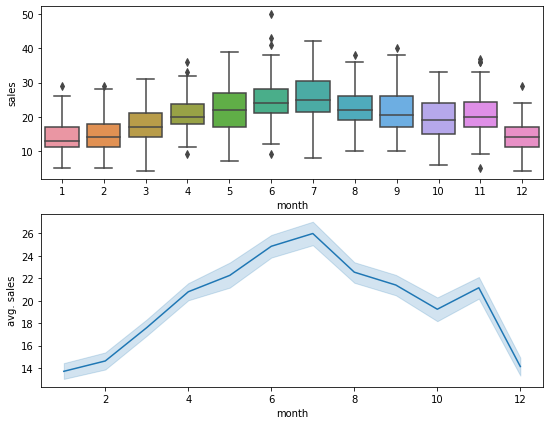

In [24]:
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=train_df, ax=axs[0])
sn.lineplot(x='month', y='sales', data=train_df, ax=axs[1])
_ = axs[1].set(ylabel='avg. sales')

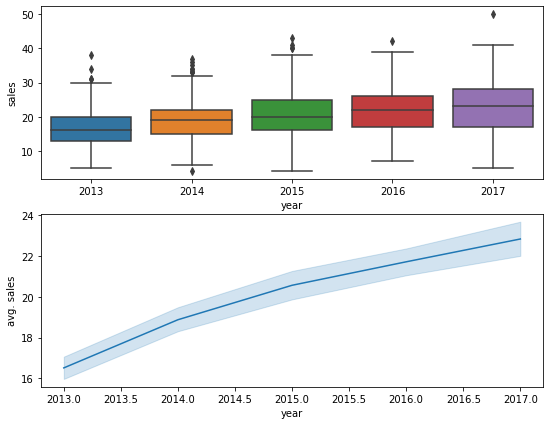

In [25]:
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=train_df, ax=axs[0])
sn.lineplot(x='year', y='sales', data=train_df, ax=axs[1])
_ = axs[1].set(ylabel='avg. sales')

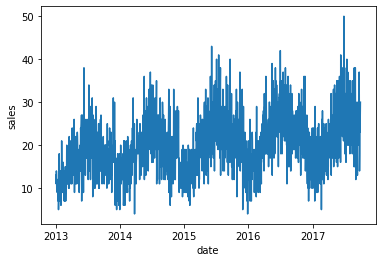

In [26]:
sn.lineplot(x='date', y='sales', data=train_df)

### Baseline Model: Seasonal Naive

In [39]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales'] 

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,date,store,item,seasonal_naive_sales
0,2017-10-01,1,1,25
1,2017-10-02,1,1,26
2,2017-10-03,1,1,20
3,2017-10-04,1,1,28
4,2017-10-05,1,1,17


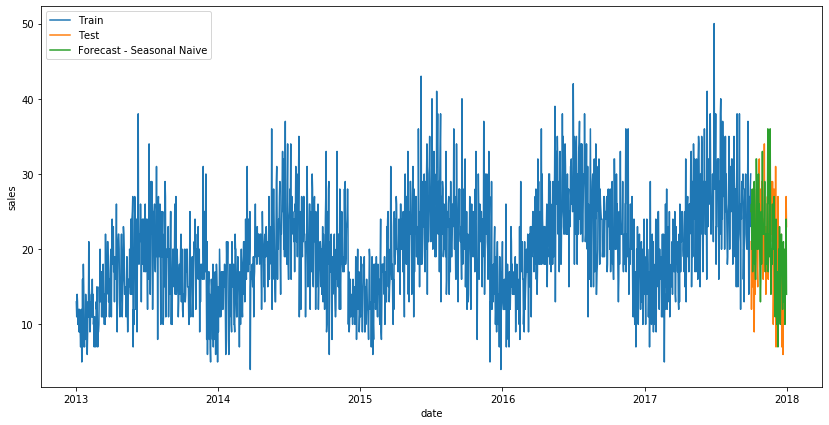

In [44]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

In [37]:
# Calculate accuracy metrics for the BASELINE Model - HERE

### Time Series Decomposition Plot

<b> Observations: </b> HERE

In [14]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day
date,,,,,,
2013-01-01,1,1,13.0,2013,1,1
2013-01-02,1,1,11.0,2013,1,2
2013-01-03,1,1,14.0,2013,1,3
2013-01-04,1,1,13.0,2013,1,4
2013-01-05,1,1,10.0,2013,1,5


<Figure size 432x288 with 0 Axes>

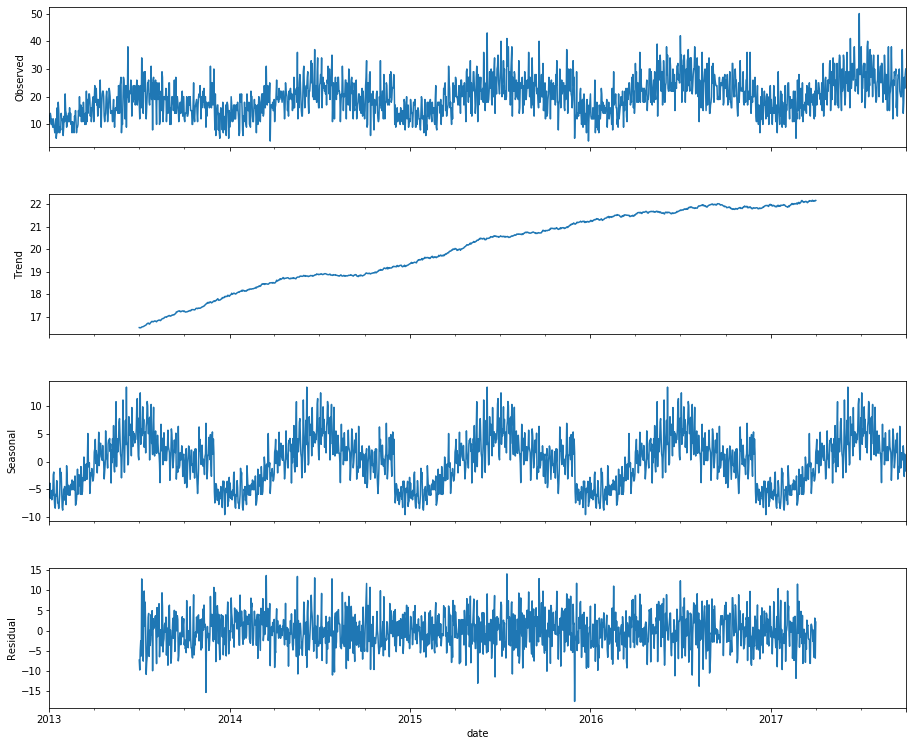

In [36]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)